In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

from code.modelhelper import *

In [2]:
N_VOCAB = 5000
N_CLASS = 2
BATCH_SIZE = 512
EPOCHS = 200

In [3]:
x = np.load("data/xy/x_word.npy")
y = np.load("data/xy/y_onehot.npy")

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42)

In [5]:
print(x.shape, y.shape)

(127284, 24) (127284, 2)


In [6]:
model_input = Input(shape=(x.shape[1], ), name="m3_input")
H = Embedding(N_VOCAB, 32, name="m3_embedding")(model_input)
H = SpatialDropout1D(0.25, name="m3_spacialdropout1d")(H)
H = LSTM(32, name="m3_lstm")(H)
model_output = Dense(N_CLASS, activation="softmax", name="m3_output")(H)

model = Model(model_input, model_output)
model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 32)            160000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 24, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 168,386
Trainable params: 168,386
Non-trainable params: 0
_________________________________________________________________


In [7]:
es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[es]
)

score = model.evaluate(x_test, y_test, verbose=2)

W0823 13:42:56.518108 4712396224 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 89098 samples, validate on 38186 samples
Epoch 1/200
89098/89098 [==============================] - 9s 103us/sample - loss: 0.2647 - accuracy: 0.8977 - val_loss: 0.1069 - val_accuracy: 0.9678
Epoch 2/200
89098/89098 [==============================] - 9s 98us/sample - loss: 0.0861 - accuracy: 0.9721 - val_loss: 0.0804 - val_accuracy: 0.9742
Epoch 3/200
89098/89098 [==============================] - 7s 84us/sample - loss: 0.0703 - accuracy: 0.9775 - val_loss: 0.0762 - val_accuracy: 0.9754
Epoch 4/200
89098/89098 [==============================] - 9s 96us/sample - loss: 0.0645 - accuracy: 0.9793 - val_loss: 0.0758 - val_accuracy: 0.9758
Epoch 5/200
89098/89098 [==============================] - 8s 89us/sample - loss: 0.0603 - accuracy: 0.9812 - val_loss: 0.0713 - val_accuracy: 0.9774
Epoch 6/200
89098/89098 [==============================] - 8s 88us/sample - loss: 0.0579 - accuracy: 0.9818 - val_loss: 0.0719 - val_accuracy: 0.9778
Epoch 7/200
89098/89098 [========================

In [8]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = to_bin(model.predict(x_test))
print("Test recall: {}".format(recall(y_test, y_pred)))

y_test0 = to_1D(y_test)
y_pred0 = to_1D(y_pred)
print(confusion_matrix(y_test0, y_pred0))

Test loss: 0.07127230922292371
Test accuracy: 0.9774263
Test recall: 0.9033816425120773
[[31340   222]
 [  640  5984]]


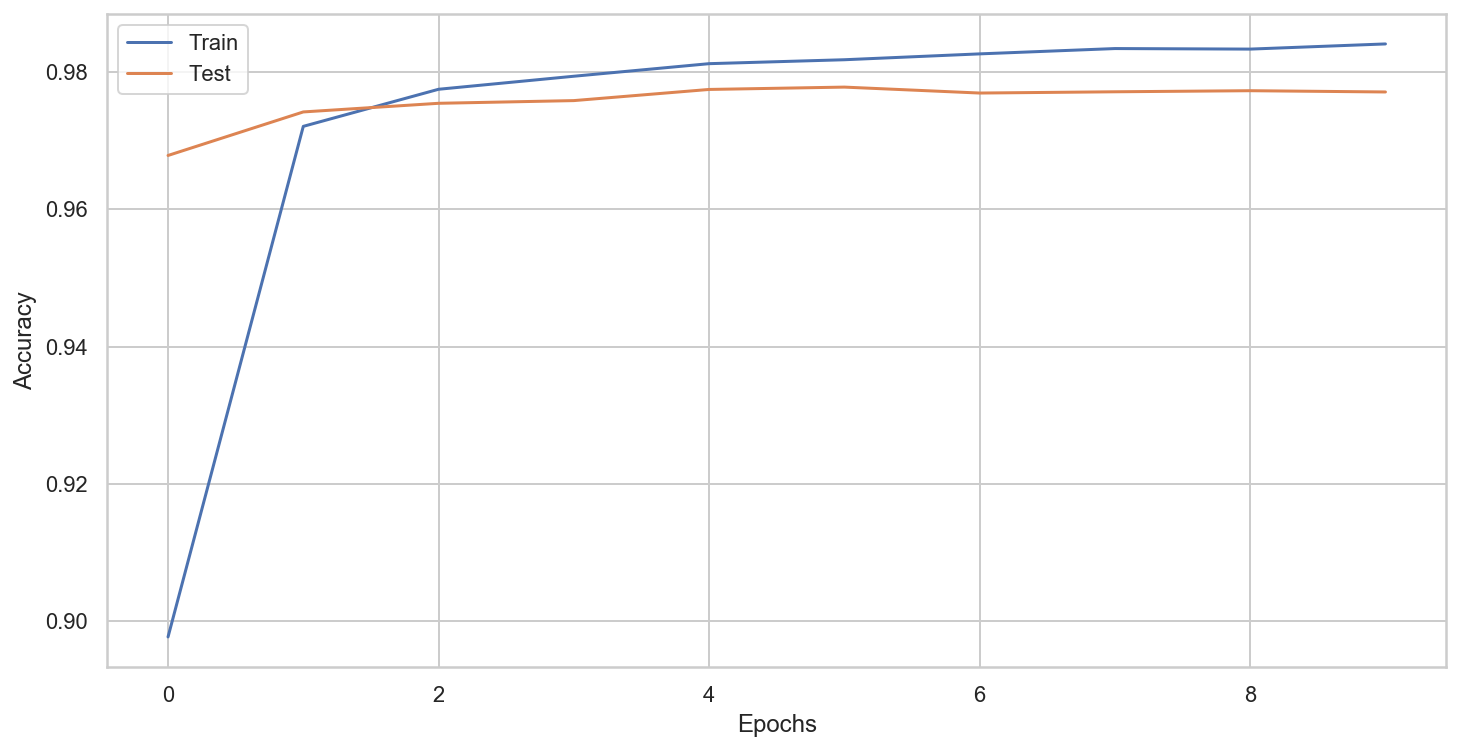

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [10]:
model.save("models/dl/m3.h5")